# 기본 설정

In [1]:
import sys
import time
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# 기본 라이브러리
import os
import json
import shutil

# PyTorch 관련 라이브러리
import torch.utils.data as data
import torch.backends.cudnn as cudnn

# 이미지 변환 관련 라이브러리
from torchvision import transforms

# 데이터 로더 및 모델, 유틸리티 함수 불러오기
from data_loader import get_segmentation_dataset  # 데이터셋 불러오는 함수
from utils.loss import MixSoftmaxCrossEntropyLoss, MixSoftmaxCrossEntropyOHEMLoss  # 손실 함수
from utils.lr_scheduler import LRScheduler  # 학습률 스케줄러
from utils.metric import SegmentationMetric  # 평가 지표

from modules import conv3x3, conv1x1, DWConvBNAct, PWConvBNAct, ConvBNAct, Activation, SegHead
from model_registry import register_model, aux_models

# Python 모듈 경로에 'models' 폴더 추가
models_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/models"

if models_path not in sys.path:
    sys.path.append(models_path)  # models 폴더 추가
    
# sys.path 확인 (제대로 추가되었는지)
print("Python 경로 목록:")
print("\n".join(sys.path))

train_img_path = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/train"
dataset_root = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets"

Python 경로 목록:
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python39.zip
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/lib-dynload

/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages
/home/segmentsafestep/miniconda3/envs/jupyter-env/lib/python3.9/site-packages/IPython/extensions
/home/segmentsafestep/.ipython
/home/segmentsafestep/Fast-SCNN-pytorch-master/models


In [2]:
import torch

# GPU가 가능하면 사용하고, 아니면 CPU 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("현재 사용 중인 디바이스:", device)
if torch.cuda.is_available():
    print("사용 중인 GPU:", torch.cuda.get_device_name(0))

현재 사용 중인 디바이스: cuda
사용 중인 GPU: NVIDIA L4


# 모델 설정

In [3]:
# BiSeNetV2 모델 정의
@register_model(aux_models)  # 모델을 등록하는 Decorator (사용자 정의 모델 등록을 위한 코드)
class BiSeNetv2(nn.Module):
    def __init__(self, num_class=1, n_channel=3, act_type='relu', use_aux=True):
        super().__init__()
        self.use_aux = use_aux  # 보조 분류(head) 사용 여부 설정 (True일 경우 보조 출력 사용)

        # 상세한 특징을 추출하는 Branch
        self.detail_branch = DetailBranch(n_channel, 128, act_type)

        # 의미론적 특징(Semantic Feature)을 추출하는 Branch
        self.semantic_branch = SemanticBranch(n_channel, 128, num_class, act_type, use_aux)

        # 두 개의 Branch에서 나온 특징을 합치는 Layer
        self.bga_layer = BilateralGuidedAggregationLayer(128, 128, act_type)

        # 최종 Segmentation 결과를 출력하는 Segmentation Head
        self.seg_head = SegHead(128, num_class, act_type)

    def forward(self, x, is_training=False):
        size = x.size()[2:]  # 원본 입력 크기 저장 (업샘플링에 사용)
        x_d = self.detail_branch(x)  # Detail Branch 실행 (미세한 특징 추출)

        # 보조 분류 사용 여부에 따라 처리 방식 결정
        if self.use_aux:
            x_s, aux2, aux3, aux4, aux5 = self.semantic_branch(x)  # Semantic Branch 실행
        else:
            x_s = self.semantic_branch(x)

        x = self.bga_layer(x_d, x_s)  # 두 개의 Branch 출력 합성
        x = self.seg_head(x)  # 최종 Segmentation 결과 출력
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)  # 원본 크기로 업샘플링

        # 보조 분류 사용 여부에 따라 추가 보조 출력 반환
        if self.use_aux and is_training:
            return x, (aux2, aux3, aux4, aux5)
        else:
            return x
        
# Detail Branch: 고해상도 특징을 유지하면서 세부 정보를 추출
class DetailBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__(
            ConvBNAct(in_channels, 64, 3, 2, act_type=act_type),  # 입력 채널 → 64 채널 변환, 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산 (필터 유지)
            ConvBNAct(64, 64, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(64, 64, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(64, 128, 3, 1, act_type=act_type),  # 채널 확장
            ConvBNAct(128, 128, 3, 2, act_type=act_type),  # 다운샘플링
            ConvBNAct(128, 128, 3, 1, act_type=act_type),  # Conv 연산
            ConvBNAct(128, out_channels, 3, 1, act_type=act_type)  # 최종 출력
        )
        
# Semantic Branch: 저해상도 특징을 추출하면서 의미론적 정보를 학습
class SemanticBranch(nn.Sequential):
    def __init__(self, in_channels, out_channels, num_class, act_type='relu', use_aux=False):
        super().__init__()
        self.use_aux = use_aux  # 보조 출력을 사용할지 여부

        # 첫 번째 단계: 초기 Feature 추출
        self.stage1to2 = StemBlock(in_channels, 16, act_type)

        # 두 번째 단계: 저해상도 특징 추출
        self.stage3 = nn.Sequential(
            GatherExpansionLayer(16, 32, 2, act_type),  # 다운샘플링 (16 → 32 채널)
            GatherExpansionLayer(32, 32, 1, act_type),  # Conv 연산
        )

        self.stage4 = nn.Sequential(
            GatherExpansionLayer(32, 64, 2, act_type),  # 다운샘플링 (32 → 64 채널)
            GatherExpansionLayer(64, 64, 1, act_type),  # Conv 연산
        )

        self.stage5_1to4 = nn.Sequential(
            GatherExpansionLayer(64, 128, 2, act_type),  # 다운샘플링 (64 → 128 채널)
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
            GatherExpansionLayer(128, 128, 1, act_type),
        )

        self.stage5_5 = ContextEmbeddingBlock(128, out_channels, act_type)  # 글로벌 컨텍스트 학습

        # 보조 분류기 정의 (auxiliary segmentation heads)
        if self.use_aux:
            self.seg_head2 = SegHead(16, num_class, act_type)
            self.seg_head3 = SegHead(32, num_class, act_type)
            self.seg_head4 = SegHead(64, num_class, act_type)
            self.seg_head5 = SegHead(128, num_class, act_type)

    def forward(self, x):
        x = self.stage1to2(x)
        if self.use_aux:
            aux2 = self.seg_head2(x)

        x = self.stage3(x)
        if self.use_aux:
            aux3 = self.seg_head3(x)

        x = self.stage4(x)
        if self.use_aux:
            aux4 = self.seg_head4(x)

        x = self.stage5_1to4(x)
        if self.use_aux:
            aux5 = self.seg_head5(x)

        x = self.stage5_5(x)  # 최종 의미론적 정보 추출

        if self.use_aux:
            return x, aux2, aux3, aux4, aux5
        else:
            return x
        
class StemBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.conv_init = ConvBNAct(in_channels, out_channels, 3, 2, act_type=act_type)
        self.left_branch = nn.Sequential(
                            ConvBNAct(out_channels, out_channels//2, 1, act_type=act_type),
                            ConvBNAct(out_channels//2, out_channels, 3, 2, act_type=act_type)
                    )
        self.right_branch = nn.MaxPool2d(3, 2, 1)
        self.conv_last = ConvBNAct(out_channels*2, out_channels, 3, 1, act_type=act_type)

    def forward(self, x):
        x = self.conv_init(x)
        x_left = self.left_branch(x)
        x_right = self.right_branch(x)
        x = torch.cat([x_left, x_right], dim=1)
        x = self.conv_last(x)

        return x
    
class GatherExpansionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride, act_type='relu', expand_ratio=6,):
        super().__init__()
        self.stride = stride
        hid_channels = int(round(in_channels * expand_ratio))

        layers = [ConvBNAct(in_channels, in_channels, 3, act_type=act_type)]

        if stride == 2:
            layers.extend([
                            DWConvBNAct(in_channels, hid_channels, 3, 2, act_type='none'),
                            DWConvBNAct(hid_channels, hid_channels, 3, 1, act_type='none')
                        ])
            self.right_branch = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type='none'),
                                    PWConvBNAct(in_channels, out_channels, act_type='none')
                            )
        else:
            layers.append(DWConvBNAct(in_channels, hid_channels, 3, 1, act_type='none'))

        layers.append(PWConvBNAct(hid_channels, out_channels, act_type='none'))
        self.left_branch = nn.Sequential(*layers)
        self.act = Activation(act_type)

    def forward(self, x):
        res = self.left_branch(x)

        if self.stride == 2:
            res = self.right_branch(x) + res
        else:
            res = x + res

        return self.act(res)
    
class ContextEmbeddingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.pool = nn.Sequential(
                            nn.AdaptiveAvgPool2d(1),
                            nn.BatchNorm2d(in_channels)
                    )
        self.conv_mid = ConvBNAct(in_channels, in_channels, 1, act_type=act_type)
        self.conv_last = conv3x3(in_channels, out_channels)

    def forward(self, x):
        res = self.pool(x)
        res = self.conv_mid(res)
        x = res + x
        x = self.conv_last(x)

        return x
    
class BilateralGuidedAggregationLayer(nn.Module):
    def __init__(self, in_channels, out_channels, act_type='relu'):
        super().__init__()
        self.detail_high = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels)
                        )
        self.detail_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, 2, act_type=act_type),
                                    nn.AvgPool2d(3, 2, 1)
                        )
        self.semantic_high = nn.Sequential(
                                    ConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    nn.Upsample(scale_factor=4, mode='bilinear', align_corners=True),
                                    nn.Sigmoid()
                            )
        self.semantic_low = nn.Sequential(
                                    DWConvBNAct(in_channels, in_channels, 3, act_type=act_type),
                                    conv1x1(in_channels, in_channels),
                                    nn.Sigmoid()
                            )
        self.conv_last = ConvBNAct(in_channels, out_channels, 3, act_type=act_type)

    def forward(self, x_d, x_s):
        x_d_high = self.detail_high(x_d)
        x_d_low = self.detail_low(x_d)

        x_s_high = self.semantic_high(x_s)
        x_s_low = self.semantic_low(x_s)
        x_high = x_d_high * x_s_high
        x_low = x_d_low * x_s_low

        size = x_high.size()[2:]
        x_low = F.interpolate(x_low, size, mode='bilinear', align_corners=True)
        res = x_high + x_low
        res = self.conv_last(res)

        return res

In [4]:
# 클래스 22개
model = BiSeNetv2(num_class=4)

# GPU 자동 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 GPU 또는 CPU로 옮기기
model = model.to(device)

## 가중치 파일에 담겨있는 정보 확인하기

In [5]:
# 가중치 파일 경로
pth_file = "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_indobohaeng_why29.pth"

# checkpoint 로드
checkpoint = torch.load(pth_file, map_location="cpu")

# state_dict 체크 및 처리
if "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]

    # ✅ 분석
    print("가중치 파일에 포함된 키 목록:")
    for key in checkpoint.keys():
        print(f"  - {key}")

    print("\n가중치 레이어 목록:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (더 많은 가중치가 있음)")
            break

    metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
    if metadata_keys:
        print("\n추가적인 메타데이터 포함:")
        for key in metadata_keys:
            print(f"  - {key}: {checkpoint[key]}")
    else:
        print("\n추가적인 학습 메타데이터 없음 (가중치 정보만 포함됨)")

    # ✅ head 제외하고 load
    filtered_state_dict = {}
    for k, v in state_dict.items():
        if not (k.startswith("seg_head") or k.startswith("semantic_branch.seg_head")):
            filtered_state_dict[k] = v

    missing, unexpected = model.load_state_dict(filtered_state_dict, strict=False)
    print(f"\n✅ head 제외 가중치 로드 완료!")
    if missing:
        print(f"  ⛔️ 누락된 키: {missing}")
    if unexpected:
        print(f"  ⚠️ 예상치 못한 키: {unexpected}")

else:
    print("❌ state_dict 가 없습니다. 가중치를 불러올 수 없습니다.")

가중치 파일에 포함된 키 목록:
  - epoch
  - state_dict
  - optimizer

가중치 레이어 목록:
  - detail_branch.0.0.weight: torch.Size([64, 3, 3, 3])
  - detail_branch.0.1.weight: torch.Size([64])
  - detail_branch.0.1.bias: torch.Size([64])
  - detail_branch.0.1.running_mean: torch.Size([64])
  - detail_branch.0.1.running_var: torch.Size([64])
  - detail_branch.0.1.num_batches_tracked: torch.Size([])
  - detail_branch.1.0.weight: torch.Size([64, 64, 3, 3])
  - detail_branch.1.1.weight: torch.Size([64])
  - detail_branch.1.1.bias: torch.Size([64])
  - detail_branch.1.1.running_mean: torch.Size([64])
  ... (더 많은 가중치가 있음)

추가적인 메타데이터 포함:
  - epoch: 29
  - optimizer: {'state': {0: {'momentum_buffer': tensor([[[[ 2.3596e-03,  2.5624e-03,  2.7174e-03],
          [ 1.6960e-03,  2.0196e-03,  2.1505e-03],
          [ 1.1000e-04,  1.7496e-04,  3.7007e-04]],

         [[ 8.2173e-04,  1.0657e-03,  1.0761e-03],
          [ 1.9005e-04,  4.9115e-04,  8.4646e-04],
          [-1.3791e-03, -1.1961e-03, -1.1040e-03]],

       

In [6]:
# head 초기화 됐는지 확인하기
print("\n[semantic_branch.seg_head2 weight 확인]")
for name, param in model.semantic_branch.seg_head2.named_parameters():
    print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

print("\n[semantic_branch.seg_head3 weight 확인]")
for name, param in model.semantic_branch.seg_head3.named_parameters():
    print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

print("\n[semantic_branch.seg_head4 weight 확인]")
for name, param in model.semantic_branch.seg_head4.named_parameters():
    print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

print("\n[semantic_branch.seg_head5 weight 확인]")
for name, param in model.semantic_branch.seg_head5.named_parameters():
    print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")


[semantic_branch.seg_head2 weight 확인]
0.0.weight: 0.000082, 0.048137
0.1.weight: 1.000000, 0.000000
0.1.bias: 0.000000, 0.000000
1.weight: 0.005016, 0.050266

[semantic_branch.seg_head3 weight 확인]
0.0.weight: 0.000110, 0.033963
0.1.weight: 1.000000, 0.000000
0.1.bias: 0.000000, 0.000000
1.weight: -0.000647, 0.051842

[semantic_branch.seg_head4 weight 확인]
0.0.weight: -0.000036, 0.024073
0.1.weight: 1.000000, 0.000000
0.1.bias: 0.000000, 0.000000
1.weight: -0.002114, 0.050623

[semantic_branch.seg_head5 weight 확인]
0.0.weight: -0.000069, 0.017051
0.1.weight: 1.000000, 0.000000
0.1.bias: 0.000000, 0.000000
1.weight: 0.001415, 0.051578


In [7]:
# 가중치 잘 적용됬는지 확인하기
def check_backbone_weights(model):
    print("\n🧩 [Detail Branch] 가중치 확인")
    for name, param in model.detail_branch.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [Semantic Branch - stage1to2] 가중치 확인")
    for name, param in model.semantic_branch.stage1to2.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [Semantic Branch - stage3] 가중치 확인")
    for name, param in model.semantic_branch.stage3.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [Semantic Branch - stage4] 가중치 확인")
    for name, param in model.semantic_branch.stage4.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [Semantic Branch - stage5_1to4] 가중치 확인")
    for name, param in model.semantic_branch.stage5_1to4.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [Semantic Branch - stage5_5] 가중치 확인")
    for name, param in model.semantic_branch.stage5_5.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

    print("\n🧩 [BGA Layer] 가중치 확인")
    for name, param in model.bga_layer.named_parameters():
        print(f"{name}: {param.mean().item():.6f}, {param.std().item():.6f}")

# 사용
check_backbone_weights(model)


🧩 [Detail Branch] 가중치 확인
0.0.weight: 0.000969, 0.097843
0.1.weight: 0.525095, 0.048542
0.1.bias: 0.033813, 0.083116
1.0.weight: -0.001350, 0.020541
1.1.weight: 0.530545, 0.037380
1.1.bias: -0.017695, 0.044105
2.0.weight: -0.000492, 0.019146
2.1.weight: 0.531250, 0.027608
2.1.bias: -0.007712, 0.037189
3.0.weight: -0.000450, 0.019079
3.1.weight: 0.530771, 0.024486
3.1.bias: 0.003817, 0.044448
4.0.weight: -0.000758, 0.016316
4.1.weight: 0.531170, 0.012680
4.1.bias: 0.000255, 0.019682
5.0.weight: -0.000307, 0.011715
5.1.weight: 0.531081, 0.013594
5.1.bias: -0.005738, 0.024275
6.0.weight: -0.000888, 0.013063
6.1.weight: 0.530084, 0.034276
6.1.bias: -0.019352, 0.027598
7.0.weight: -0.000190, 0.015282
7.1.weight: 0.526035, 0.011541
7.1.bias: 0.007880, 0.087693

🧩 [Semantic Branch - stage1to2] 가중치 확인
conv_init.0.weight: 0.004441, 0.243699
conv_init.1.weight: 0.394047, 0.110704
conv_init.1.bias: 0.208654, 0.330913
left_branch.0.0.weight: 0.011050, 0.210106
left_branch.0.1.weight: 0.579344, 0.1

In [8]:
print(model)  # 모델이 정상적으로 선언되었는지 확인

BiSeNetv2(
  (detail_branch): DetailBranch(
    (0): ConvBNAct(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (1): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (2): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Activation(
        (activation): ReLU()
      )
    )
    (3): ConvBNAct(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1

---

# 학습

In [9]:
# 모델 및 학습 관련 하이퍼파라미터 설정
args = {
    "model": "BiSeNetv2",  # 사용할 모델 이름
    "dataset": "surface",  # 학습할 데이터셋 (예: Cityscapes)
    "base_size": 1024,  # 입력 이미지 기본 크기
    "crop_size": 768,  # 학습 시 사용할 크롭 크기
    "train_split": "train",  # 학습 데이터셋의 분할 방식

    # 학습 하이퍼파라미터
    "aux": True,  # 보조 손실 사용 여부
    "aux_weight": 0.4,  # 보조 손실 가중치
    "epochs": 35,  # 학습 에폭 수
    "start_epoch": 0,  # 학습 시작 에폭
    "batch_size": 8,  # 배치 크기를 바꿈
    "lr": 1e-3,  # 학습률을 바꿨어. 더 크게 학습 돌려보면서 확인해봐
    "momentum": 0.9,  # 모멘텀
    "weight_decay": 1e-4,  # 가중치 감쇠 (L2 정규화)

    # 체크포인트 저장 위치
    "resume": True,  # 기존 모델 체크포인트 (사용하지 않음)
    "save_folder": "./weights",  # 모델 가중치 저장 경로

    # 평가 및 검증 설정
    "eval": False,  # 평가 모드 여부
    "no_val": True,  # 검증 생략 여부
}

# GPU 사용 여부 설정
print(device := torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
cudnn.benchmark = True  # GPU 연산 최적화
args["device"] = device  # 학습에 사용할 디바이스 저장

cuda:0


In [ ]:
"""
# Normalize 값을 4개 클래스에 맞는 것을 바꾸기 위해 데이터셋 전체에 대한 계산법 나중에 해보자
import os
import glob
import numpy as np
from PIL import Image
from tqdm import tqdm

def compute_mean_std(image_dir):
    print(f"📂 이미지 폴더: {image_dir}")
    image_paths = glob.glob(os.path.join(image_dir, "**", "*.png"), recursive=True)
    print(f"총 {len(image_paths)}개의 이미지가 있습니다.")

    # 누적 합 초기화
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)
    pixel_count = 0

    for img_path in tqdm(image_paths, desc="📊 mean / std 계산 중"):
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img) / 255.0  # [0, 1] 로 정규화

        # 채널별 합계
        channel_sum += img_np.mean(axis=(0, 1))
        channel_sum_squared += (img_np ** 2).mean(axis=(0, 1))
        pixel_count += 1

    # 평균
    mean = channel_sum / pixel_count
    std = np.sqrt(channel_sum_squared / pixel_count - mean ** 2)

    print(f"\n✅ 평균 (mean): {mean}")
    print(f"✅ 표준편차 (std): {std}")
    return mean, std

# 사용 예시
image_dir = "/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley"
compute_mean_std(image_dir)

In [10]:
# 이미지 전처리 변환 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize([0.3257, 0.3690, 0.3223], [0.2112, 0.2148, 0.2115]),  # 이미지 정규화
])

# 데이터셋 로드 (학습 및 검증)
data_kwargs = {"transform": input_transform, "base_size": args["base_size"], "crop_size": args["crop_size"]}
train_dataset = get_segmentation_dataset(args["dataset"], split=args["train_split"], mode="train", root=dataset_root, **data_kwargs)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="val", root=dataset_root, **data_kwargs)

# DataLoader 생성 (데이터 배치 단위로 로딩)
train_loader = data.DataLoader(dataset=train_dataset, batch_size=args["batch_size"], shuffle=True, num_workers=4 # 이거 수정해봐
                               , drop_last=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=1, shuffle=False)

# 모델을 GPU 또는 CPU로 이동
dev_mod = model.to(args["device"])

cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045448.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045448.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045451.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045451.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045466.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel_sur_045466.png
cannot find the mask or image: /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/leftImg8bit/Train/alley/MP_SEL_SUR_045472.jpg /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/indobohaeng/gtFine/Train/alley/mp_sel

# 체크포인트

In [11]:
# 손실 함수 설정 (OHEM Loss 사용)
criterion = MixSoftmaxCrossEntropyLoss(aux=args["aux"], aux_weight=args["aux_weight"], ignore_label=-1).to(args["device"])

# 옵티마이저 (SGD 사용)
optimizer = torch.optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"], weight_decay=args["weight_decay"])

# 학습률 스케줄러 설정 (poly decay 사용)
lr_scheduler = LRScheduler(mode="poly", base_lr=args["lr"], nepochs=args["epochs"],
                           iters_per_epoch=len(train_loader), power=0.9)

# 평가 지표 (mIoU 등)
metric = SegmentationMetric(train_dataset.num_class)

# 최고 성능 저장을 위한 변수
best_pred = 0.0

In [12]:
# 클래스 매핑 (원본 22 클래스 → 4 클래스)
class_map = {
    17: 0, 16: 0,
    9: 1, 10: 1, 11: 1, 12: 1, 13: 1,
    0: 2, 1: 2, 2: 2, 3: 2, 4: 2, 6: 2,
    5: 3, 7: 3, 8: 3, 14: 3, 15: 3, 18: 3, 19: 3, 20: 3, 21: 3
}

# label mapping 함수
def map_labels(target, class_map):
    target_np = target.cpu().numpy()
    mapped = np.vectorize(lambda x: class_map.get(x, 3))(target_np)  # 없으면 background로
    return torch.from_numpy(mapped).long().to(target.device)

In [13]:
def train():
    global best_pred
    cur_iters = 0
    start_epoch = 0
    history = {"epoch": [], "loss": [], "lr": []}

    os.makedirs(args["save_folder"], exist_ok=True)

    # ✅ checkpoint resume (state_dict 은 head 제외하고 이미 불러옴!)
    if os.path.exists(pth_file) and args["resume"]:
        print(f"체크포인트 {pth_file} 불러오는 중...")
        checkpoint = torch.load(pth_file, map_location=args["device"])
    
        # ❌ optimizer 복원 제거
        # if "optimizer" in checkpoint:
        #     optimizer.load_state_dict(checkpoint["optimizer"])
        #     print("옵티마이저 state 복원 완료!")
        # else:
        #     print("옵티마이저 state 없음")
    
        if "epoch" in checkpoint:
            start_epoch = checkpoint["epoch"] + 1
            print(f"{start_epoch} 에폭부터 이어서 학습을 시작합니다.")
        else:
            print("⚠️ 에폭 정보 없음. 처음부터 시작합니다.")
    
    else:
        print("체크포인트가 존재하지 않거나 resume=False 입니다. 처음부터 학습을 시작합니다.")

    # 에폭 루프
    for epoch in range(start_epoch, args["epochs"]):
        model.train()
        epoch_loss = 0.0
        epoch_start_time = time.time()

        # 미니배치 루프
        for i, (images, targets) in enumerate(train_loader):
            cur_lr = lr_scheduler(cur_iters)
            for param_group in optimizer.param_groups:
                param_group["lr"] = cur_lr

            images, targets = images.to(args["device"]), targets.to(args["device"])

            # 🎯 label mapping
            targets = map_labels(targets, class_map)

            outputs = model(images)
            loss = criterion((outputs,), targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            cur_iters += 1

            if cur_iters % 300 == 0:
                print(f"Epoch [{epoch}/{args['epochs']}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch} 완료! 소요 시간: {epoch_time:.2f} 초")

        # 로그 저장
        avg_loss = epoch_loss / len(train_loader)
        history["epoch"].append(epoch)
        history["loss"].append(avg_loss)
        history["lr"].append(cur_lr)

        # 모델 저장
        save_path = os.path.join(args["save_folder"], f"model_indobohaeng_4class_{epoch}.pth")
        torch.save({
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "loss": avg_loss
        }, save_path)
        print(f"모델 가중치 저장됨: {save_path}")

        # validation (5에폭마다 or 매 에폭마다)
        if not args["no_val"] and epoch % 5 == 0:
            validation(epoch)

    # 학습 히스토리 저장
    history_path = os.path.join(args["save_folder"], "train_history_smpl_4class.json")
    with open(history_path, "w") as f:
        json.dump(history, f)
    print(f"학습 히스토리 저장 완료: {history_path}")

In [14]:
# ✅ Validation 함수 (label 매핑 포함)
def validation(epoch):
    global best_pred
    model.eval()
    metric.reset()

    import time
    val_start_time = time.time()

    with torch.no_grad():
        for i, (image, target) in enumerate(val_loader):
            image = image.to(args["device"])
            target = target.to(args["device"])

            # 🎯 label 매핑
            target = map_labels(target, class_map)

            outputs = (model(image),)

            pred = torch.argmax(outputs[0], 1).cpu().data.numpy()
            metric.update(pred, target.cpu().numpy())

    pixAcc, mIoU = metric.get()
    print(f"Epoch {epoch}, Validation Pixel Acc: {pixAcc:.3f}, mIoU: {mIoU:.3f}")

    new_pred = (pixAcc + mIoU) / 2
    if new_pred > best_pred:
        best_pred = new_pred

    val_duration = time.time() - val_start_time
    print(f" - 검증 소요 시간: {val_duration:.2f} 초")

    return mIoU

In [15]:
train()

체크포인트 /home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_indobohaeng_why29.pth 불러오는 중...
30 에폭부터 이어서 학습을 시작합니다.
Epoch [30/35], Step [299/2882], Loss: 0.1090
Epoch [30/35], Step [599/2882], Loss: 0.4834
Epoch [30/35], Step [899/2882], Loss: 0.5293
Epoch [30/35], Step [1199/2882], Loss: 0.6804
Epoch [30/35], Step [1499/2882], Loss: 0.1160
Epoch [30/35], Step [1799/2882], Loss: 0.7877


KeyboardInterrupt: 

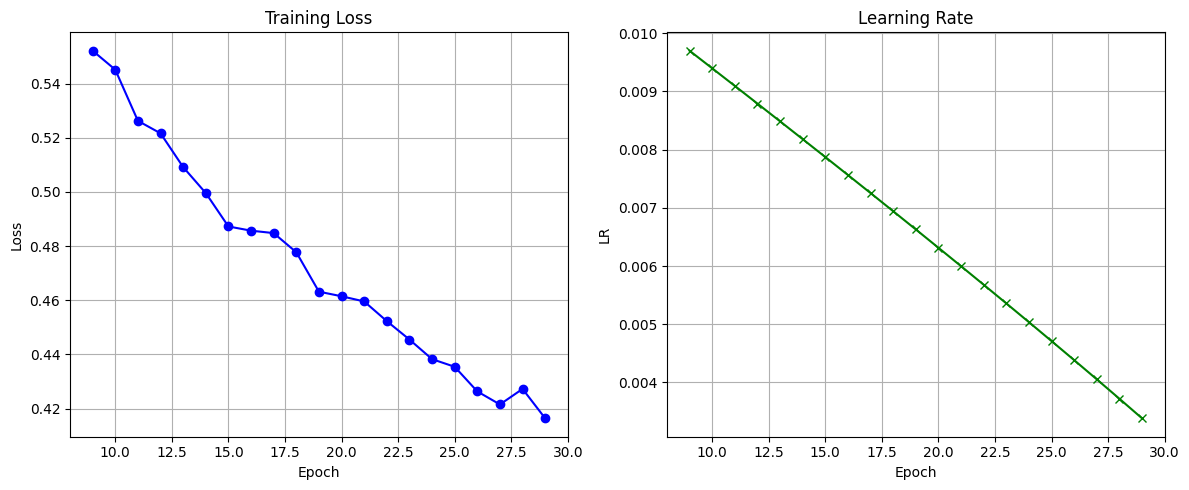

In [1]:
import json
import matplotlib.pyplot as plt

# 경로
history_path = "./weights/train_history_smpl_city.json"

# 파일 로드
with open(history_path, "r") as f:
    history = json.load(f)

epochs = history["epoch"]
losses = history["loss"]
lrs = history["lr"]

# 그래프 그리기
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', color='blue')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Learning Rate 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, lrs, marker='x', color='green')
plt.title("Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.grid(True)

plt.tight_layout()
plt.show()

# 체크포인트 불러오기 (resume=True일 때)
    if args["resume"]:
        if os.path.exists(chk_pnt_path):  # 가중치 파일이 있는지 확인
            print(f"이전 학습 가중치 불러오는 중: {chk_pnt_path}")
            checkpoint = torch.load(chk_pnt_path, map_location=args["device"])
            model.load_state_dict(checkpoint["state_dict"])  # 모델 가중치 로드
            checkpoint_state = {
                k: v for k, v in checkpoint["state_dict"].items()
                if not k.startswith("seg_head") and not k.startswith("semantic_branch.seg_head")
            }

            # 확인용 로그
            # print(f"[Check] 불러온 checkpoint epoch: {checkpoint.get('epoch', '정보 없음')}")
            # print(f"[Check] 불러온 state_dict 파라미터 수: {len(checkpoint_state)}개")
            # first_key = list(checkpoint_state.keys())[0]
            # print(f"[Check] 첫 번째 레이어 키: {first_key}")
            # print(f"[Check] 해당 파라미터 일부 값: {checkpoint_state[first_key].view(-1)[:5]}")

            start_epoch = checkpoint.get("epoch", -1) + 1
            print(f"학습을 {start_epoch}번째 에포크부터 이어서 진행합니다.")
        else:
            print("지정된 체크포인트 파일을 찾을 수 없습니다. 처음부터 학습을 시작합니다.")
            start_epoch = args["start_epoch"]
    else:
        start_epoch = args["start_epoch"]

In [19]:
for i, (image, target) in enumerate(val_loader):
    image = image.to(args["device"])
    
    model.eval()  # 모델을 평가 모드로 설정 (BatchNorm 문제 해결)

    with torch.no_grad():
        output = model(image)  # 리스트에 저장하지 않고 바로 사용
        output = output.argmax(dim=1).cpu().numpy()  # 필요하면 바로 NumPy로 변환

In [20]:
out = outputs[0][0]

# out = F.interpolate(out, size=org_size, align_corners=False, mode='bilinear')
print(out.shape)
out = out.argmax(dim=1)
print(out.shape)

# visualize
out = out.squeeze().detach().cpu().numpy()
pred = palette[out] # 앞서 컬러 팔레트는 랜덤으로 세팅


NameError: name 'outputs' is not defined

In [21]:
import matplotlib.pyplot as plt

plt.imshow(pred)  # 세그멘테이션 결과 이미지 출력
plt.axis("off")  # 축 제거 (선택 사항)
plt.show()

NameError: name 'pred' is not defined

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# 예측된 결과를 정수 클래스 ID로 변환
out = outputs[0][0].argmax(dim=1).cpu().numpy()

# 예측된 클래스 ID 중 실제로 등장한 클래스 찾기
unique_class_ids = np.unique(out)  # 예측된 클래스 ID
detected_classes = [CITYSCAPES_CLASSES[i] for i in unique_class_ids]  # 클래스 이름 매칭

# 클래스 ID를 색상 팔레트로 변환
pred = np.zeros((*out.shape, 3), dtype=np.uint8)  # RGB 이미지 형태 생성
for class_id in unique_class_ids:
    pred[out == class_id] = CITYSCAPES_COLORS[CITYSCAPES_CLASSES[class_id]]

# 불필요한 차원 제거 (Matplotlib이 올바르게 인식하도록)
pred = np.squeeze(pred)  # (1, H, W, 3) → (H, W, 3)으로 변경

# 시각화 (클래스별 색상 범례 추가)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 클래스 범례 출력
axes[0].imshow(pred)  # 수정된 `pred`를 사용
axes[0].set_title("Segmentation Result")
axes[0].axis("off")

# 클래스별 색상 범례 추가
patches = [mpatches.Patch(color=np.array(CITYSCAPES_COLORS[class_name]) / 255.0, label=class_name)
           for class_name in detected_classes]
axes[1].legend(handles=patches, loc="center", fontsize="small", title="Classes")
axes[1].axis("off")

plt.tight_layout()
plt.show()

NameError: name 'outputs' is not defined

---

# miou 확인하기

In [15]:
# 기본 라이브러리
import os
import torch
import torch.utils.data as data
from data_loader import get_segmentation_dataset  # 데이터셋 로드 함수
from utils.metric import SegmentationMetric  # 평가 지표

In [22]:
# 설정 (Jupyter Notebook 환경에 맞게 변경)
args = {
    "dataset": "citys",  # 사용할 데이터셋 (Cityscapes)
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),  # GPU/CPU 설정
    "batch_size": 1,  # 평가 시 배치 크기
    "num_workers": 0,  # DataLoader의 worker 개수 (메모리 문제 방지 위해 0으로 설정)
    "weight_path": "/home/segmentsafestep/Fast-SCNN-pytorch-master/weights/model_2class_5.pth"  # 저장된 가중치 경로
}

In [23]:
# 가중치 파일 확인
if not os.path.exists(args["weight_path"]):
    raise FileNotFoundError(f"가중치 파일이 존재하지 않습니다: {args['weight_path']}")

# 이미지 전처리 설정
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([.485, .456, .406], [.229, .224, .225]),
])

In [24]:
# 검증 데이터셋 로드 (Cityscapes val set)
val_dataset = get_segmentation_dataset(args["dataset"], split="val", mode="testval", transform=input_transform, root="/home/segmentsafestep/Fast-SCNN-pytorch-master/datasets")
val_loader = data.DataLoader(
    dataset=val_dataset,
    batch_size=args["batch_size"],
    shuffle=False,
    num_workers=args["num_workers"]
)

# 모델 및 가중치 로드
# model = BiSeNetv2(num_class=val_dataset.num_class).to(args["device"])  # 모델 생성

# 저장된 가중치 파일 로드
checkpoint = torch.load(args["weight_path"], map_location=args["device"])

# 가중치 파일에 state_dict가 포함되어 있으면, 모델 가중치만 추출하여 로드
if "state_dict" in checkpoint:
    model.load_state_dict(checkpoint["state_dict"])  # state_dict만 로드
else:
    model.load_state_dict(checkpoint)  # 이미 순수한 가중치 파일이면 그대로 로드

model.eval()  # 모델을 평가 모드로 설정
print("모델 및 가중치 로드 완료!")

# 평가 지표 설정 (mIoU 및 픽셀 정확도)
metric = SegmentationMetric(val_dataset.num_class)

Found 500 images in /home/segmentsafestep/Fast-SCNN-pytorch-master/datasets/citys/leftImg8bit/val
모델 및 가중치 로드 완료!


In [25]:
# 검증 수행 및 mIoU 계산
print("검증 데이터셋 평가 중...")
with torch.no_grad():
    for i, (image, label) in enumerate(val_loader):
        image = image.to(args["device"])
        label = label.cpu().numpy().squeeze()  # GPU -> CPU 후 불필요한 차원 제거

        # 모델 예측 수행
        outputs = model(image)

        # 모델 출력이 (C, W)로 잘못 나오는 경우, 올바르게 변환
        if len(outputs.shape) == 3:  # (C, H, W) 형태라면 batch 차원이 없음 -> 추가
            outputs = outputs.unsqueeze(0)  # (1, C, H, W) 형태로 변환
        elif len(outputs.shape) == 2:  # (C, W) 형태라면 차원 재배열 필요
            outputs = outputs.view(1, outputs.shape[0], 1, outputs.shape[1])  # (1, C, 1, W)로 변환
        
        # 예측 결과 계산
        pred = torch.argmax(outputs, dim=1).cpu().numpy().squeeze()  # (H, W) 형태로 변환
        
        # 평가 지표 업데이트
        metric.update(pred, label)

        # 10개마다 중간 결과 출력
        if (i + 1) % 10 == 0:
            pixAcc, mIoU = metric.get()
            print(f"Sample {i+1}: Pixel Accuracy = {pixAcc * 100:.2f}%, mIoU = {mIoU * 100:.2f}%")

# 최종 평가 결과 출력
final_pixAcc, final_mIoU = metric.get()
print("\n최종 평가 결과")
print(f"Pixel Accuracy: {final_pixAcc * 100:.2f}%")
print(f"Mean IoU (mIoU): {final_mIoU * 100:.2f}%")

검증 데이터셋 평가 중...
Sample 10: Pixel Accuracy = 40.09%, mIoU = 8.79%
Sample 20: Pixel Accuracy = 38.77%, mIoU = 8.36%
Sample 30: Pixel Accuracy = 38.20%, mIoU = 9.09%


KeyboardInterrupt: 

## 가중치 파일에 담겨있는 정보 확인하기

In [24]:
import torch

# 가중치 파일 경로
pth_file = "/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth"

# 가중치 파일 로드
checkpoint = torch.load(pth_file, map_location="cpu")

# 가중치 파일에 저장된 key 목록 출력
print("가중치 파일에 포함된 키 목록:")
for key in checkpoint.keys():
    print(f"  - {key}")

# 모델 가중치가 저장된 키가 있는지 확인
if "state_dict" in checkpoint:
    print("\n'state_dict' 키가 포함됨 (모델 가중치 포함)")
    state_dict = checkpoint["state_dict"]

    # 가중치 레이어 이름 출력 (최대 10개만)
    print("\n가중치 레이어 목록:")
    for i, (name, param) in enumerate(state_dict.items()):
        if i < 10:  # 10개까지만 출력
            print(f"  - {name}: {param.shape}")
        else:
            print("  ... (더 많은 가중치가 있음)")
            break
else:
    print("\n'state_dict' 키가 없음 (모델 가중치가 저장되지 않은 파일일 수 있음)")

# 체크포인트 파일에 다른 정보(예: 학습률, 에포크 등)가 저장되어 있는지 확인
metadata_keys = [key for key in checkpoint.keys() if key != "state_dict"]
if metadata_keys:
    print("\n추가적인 메타데이터 포함:")
    for key in metadata_keys:
        print(f"  - {key}: {checkpoint[key]}")
else:
    print("\n추가적인 학습 메타데이터 없음 (가중치 정보만 포함됨)")

FileNotFoundError: [Errno 2] No such file or directory: '/aiffel/aiffel/aiffel project model training/Fast-SCNN-pytorch-master/weights/bisenetv2-aux.pth'

# 이미지 테스트